In [1]:
from collections import deque
from itertools import chain
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

from q_net import QNet, QNetDueling
from common_components import env, MAX_STEPS


# MAX_STEPS = 500  # you may want to override MAX_STEPS from common_components


n_state_params = env.observation_space.shape[0]
n_actions = env.action_space.n

In [2]:
def plot_rews_lens(*, rews, lens, window_n=10):
    """Plots episode rewards and lengths, averaged with sliding mean window size window_n."""
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)

    lens_ = np.convolve(lens, np.ones(window_n) / window_n, mode='valid')
    rews_ = np.convolve(rews, np.ones(window_n) / window_n, mode='valid')

    ax = axs[0]
    ax.plot(rews_, c='darkred')
    ax.set_title('Mean episode rewards')

    ax = axs[1]
    ax.plot(lens_, c='navy')
    ax.set_title('Mean episode lengthes')

    for ax in axs:
        ax.set_xticks([])
    plt.tight_layout();

---
# Simple Q-Net training

## Model & Optimizer

In [31]:
model = QNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [41]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

0.0001


In [38]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.0001

## Training

In [32]:
lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 1000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

state = env.reset()

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()

    for step in range(STEPS):
        model.train()
        q_pred = model(torch.tensor(state).unsqueeze(0)).squeeze()
        
        action = np.random.choice([torch.argmax(q_pred), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)
        
        q_target = q_pred.clone().detach()
        if is_done:
            q_target[action] = reward
        else:
            model.eval()
            with torch.no_grad():
                q_target[action] = reward + GAMMA * model(torch.tensor(new_state).unsqueeze(0)).max()

        loss = F.mse_loss(q_pred, q_target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = new_state
        total_epoch_reward += reward
        
        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
    
        if is_done:
            break
    
    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

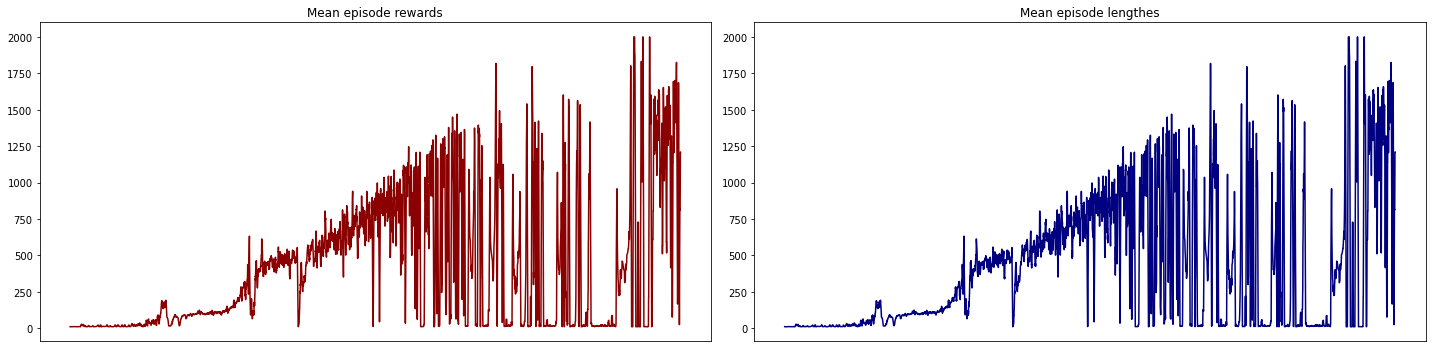

In [94]:
plot_rews_lens(rews=rews, lens=lens, window_n=10)

## Save

In [95]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')

---
# Dueling Q-Net training

## Model & Optimizer

In [123]:
model = QNetDueling()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [131]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

0.001


In [143]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.001

## Training

In [124]:
lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 1000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

state = env.reset()

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()

    for step in range(STEPS):
        model.train()
        v, a = model(torch.tensor(state).unsqueeze(0))
        q_pred = (v + a - a.mean()).squeeze()
        
        action = np.random.choice([torch.argmax(a), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)

        q_target = q_pred.clone().detach()
        if is_done:
            q_target[action] = reward
        else:
            model.eval()
            with torch.no_grad():
                v, a = model(torch.tensor(new_state).unsqueeze(0))
            q_target[action] = reward + GAMMA * (v + a - a.mean()).squeeze().max()
        
        loss = F.mse_loss(q_pred, q_target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = new_state
        total_epoch_reward += reward
        
        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
        
        if is_done:
            break
    
    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

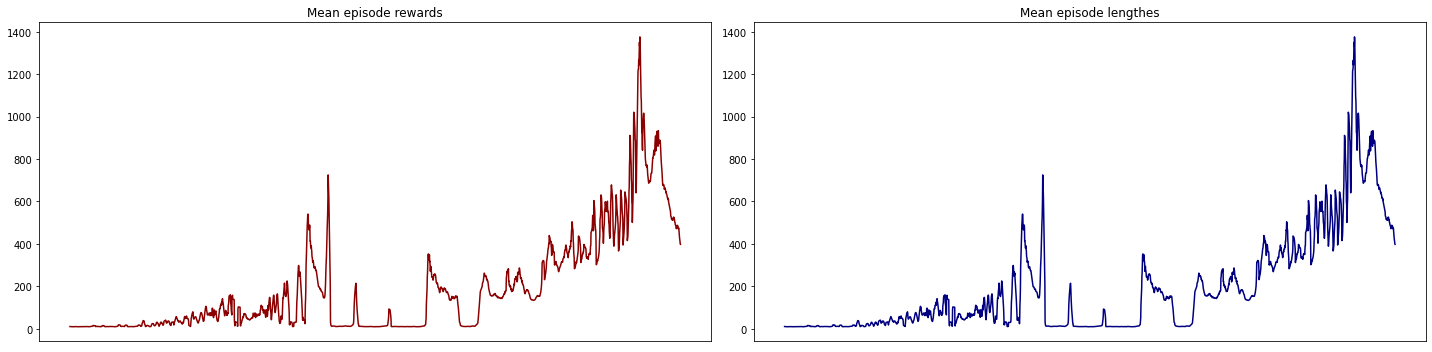

In [149]:
plot_rews_lens(rews=rews, lens=lens, window_n=10)

## Save

In [140]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')

---
# Double (fast-slow) Q-Net training

## Model & Optimizer

In [208]:
model = QNet().eval()
model_f = QNet()
optimizer = torch.optim.Adam(model_f.parameters(), lr=0.01)

In [204]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

0.0001


In [215]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.0001

## Training

In [209]:
lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 1000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

UPDATE_INTERVAL = 100  # interval to update slow model

state = env.reset()

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()

    for step in range(STEPS):
        model_f.train()
        q_pred = model_f(torch.tensor(state).unsqueeze(0)).squeeze()

        action = np.random.choice([torch.argmax(q_pred), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)

        q_target = q_pred.clone().detach()
        if is_done:
            q_target[action] = reward
        else:
            model_f.eval()
            with torch.no_grad():
                q_target[action] = reward + GAMMA * model(torch.tensor(new_state).unsqueeze(0)).max()
        
        loss = F.mse_loss(q_pred, q_target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not step % UPDATE_INTERVAL:
            model.load_state_dict(model_f.state_dict().copy())
            
        state = new_state
        total_epoch_reward += reward
        
        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
        
        if is_done:
            break
    
    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

model.load_state_dict(model_f.state_dict().copy());

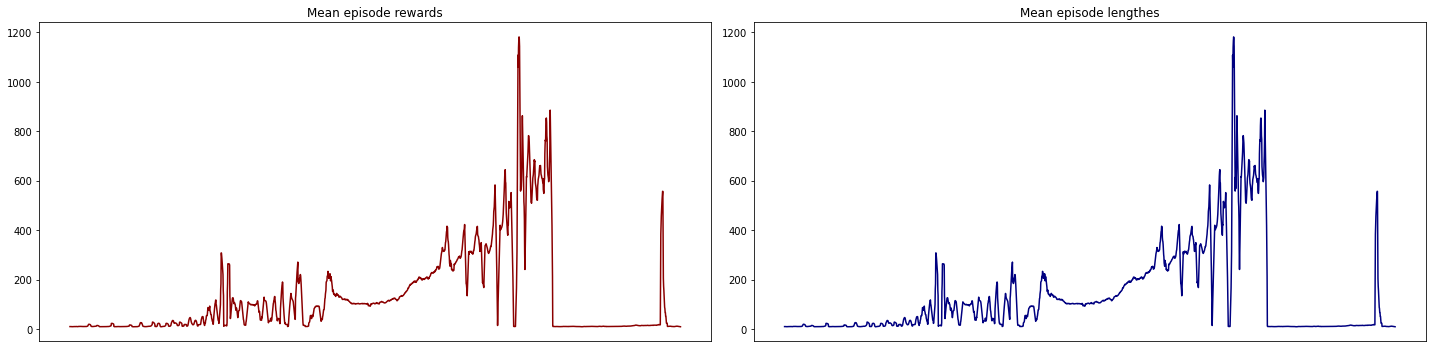

In [221]:
plot_rews_lens(rews=rews, lens=lens, window_n=10)

## Save

In [85]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')

---
# Minibatch Q-Net training

## Model & Optimizer

In [250]:
model = QNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [238]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

0.001


In [239]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.01

## Training

In [251]:
lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 10000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

BATCH_SIZE = 100

state = env.reset()
global_step = 1
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()

    for step in range(STEPS):
        model.train()
        q_pred = model(torch.tensor(state).unsqueeze(0)).squeeze()
        
        action = np.random.choice([torch.argmax(q_pred), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)
        
        q_target = q_pred.clone().detach()
        if is_done:
            q_target[action] = reward
        else:
            model.eval()
            with torch.no_grad():
                q_target[action] = reward + GAMMA * model(torch.tensor(new_state).unsqueeze(0)).max()

        loss = F.mse_loss(q_pred, q_target.detach())

        loss.backward(retain_graph=True)
        if not global_step % BATCH_SIZE:
            # for p in model.parameters():
            #     p.grad /= BATCH_SIZE
            optimizer.step()
            optimizer.zero_grad()

        state = new_state
        total_epoch_reward += reward
        
        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
    
        global_step += 1

        if is_done:
            break

    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

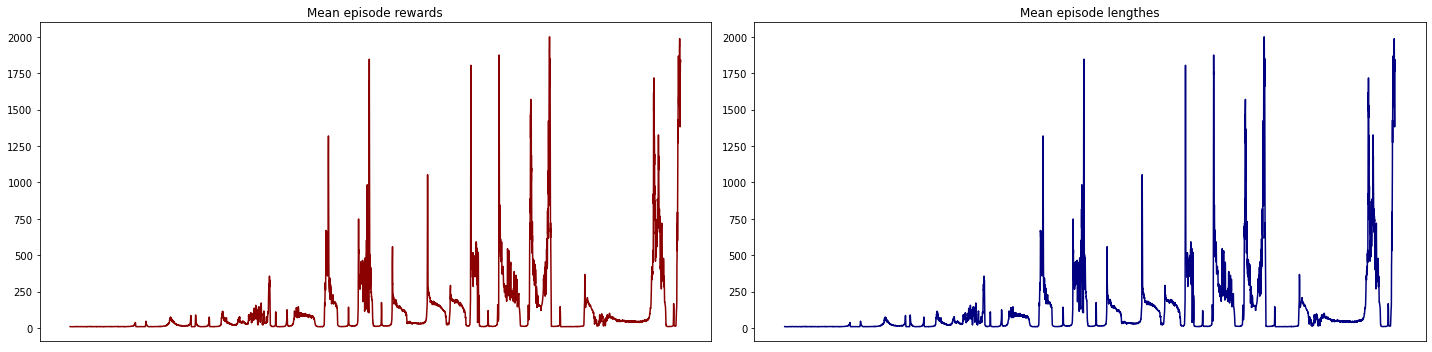

In [257]:
plot_rews_lens(rews=rews, lens=lens, window_n=10)

## Save

In [258]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')

---
# Q-Net training with BUFFER (with BUFFER_TAKE as minibatch)

## Model & Optimizer

In [29]:
model = QNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

In [320]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.003

## Training

In [30]:
BUFFER_LEN = 100000

buffer = deque(maxlen=BUFFER_LEN)

lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 1000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

BUFFER_PUT = 1  # new saamples (state, action, reward, new_state, is_done) samples to put to buffer before model update
BUFFER_TAKE = 100  # samples to take from buffer 

state = env.reset()

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()

    for step in range(STEPS):
        model.eval()
        with torch.no_grad():
            q_pred = model(torch.tensor(state).unsqueeze(0))

        action = np.random.choice([torch.argmax(q_pred), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)
        buffer.append((state, action, reward, new_state, is_done))

        total_epoch_reward += reward

        if not step % BUFFER_PUT :
            new_state_ = new_state
            is_done_ = is_done
            for state, action, reward, new_state, is_done in random.choices(buffer, k=BUFFER_TAKE):
                model.train()
                q_pred = model(torch.tensor(state).unsqueeze(0)).squeeze()

                q_target = q_pred.clone().detach()
                if is_done:
                    q_target[action] = reward
                else:
                    model.eval()
                    with torch.no_grad():
                        q_target[action] = reward + GAMMA * model(torch.tensor(new_state).unsqueeze(0)).max()
                
                loss = F.mse_loss(q_pred, q_target.detach())

                loss.backward(retain_graph=True)
                
            # for p in model.parameters():
            #     p.grad /= BUFFER_TAKE
            optimizer.step()
            optimizer.zero_grad()

            is_done = is_done_
            state = new_state_
            
        else:
            state = new_state

        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
        
        if is_done:
            break

    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

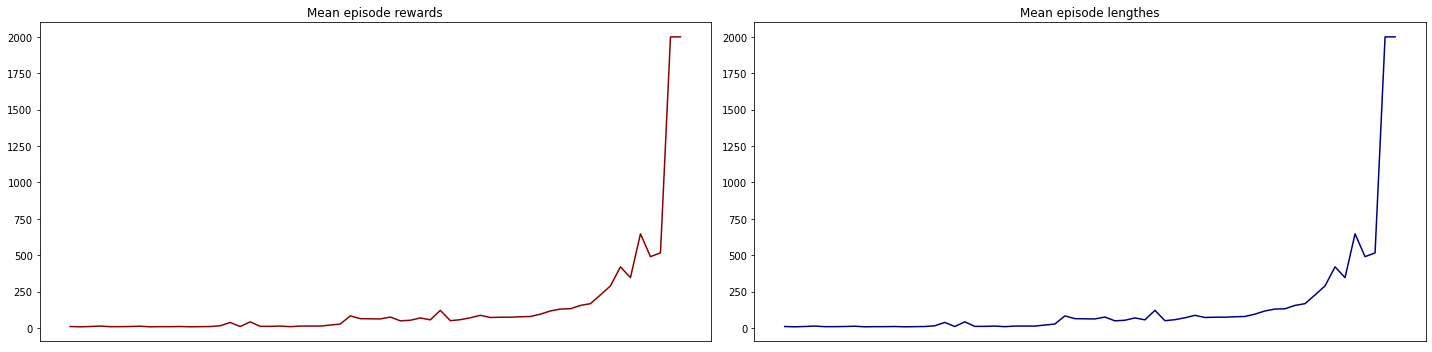

In [7]:
plot_rews_lens(rews=rews, lens=lens, window_n=1)

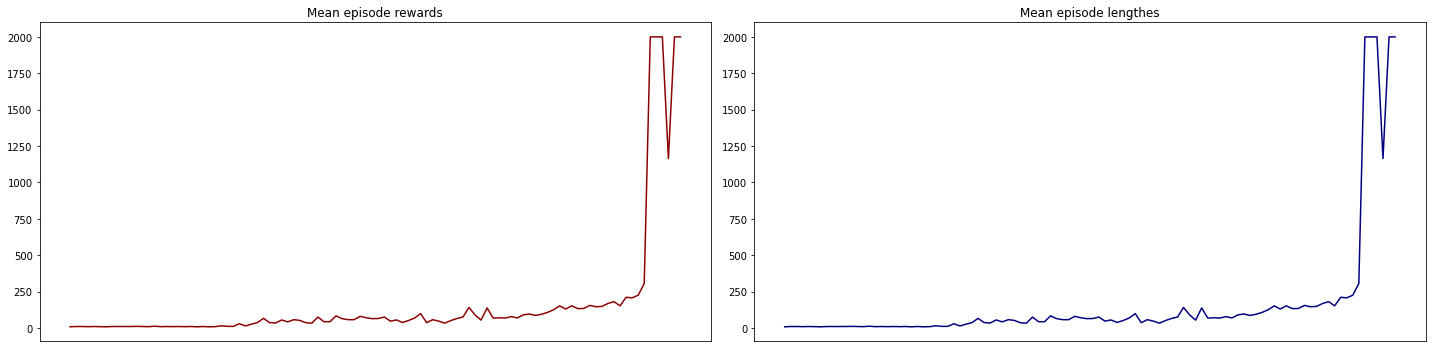

In [8]:
plot_rews_lens(rews=rews, lens=lens, window_n=1)

## Save

In [319]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')

---
# Double Q-net + BUFFER (with BUFFER_TAKE as minibatch)

In [53]:
model = QNet().eval()
model_f = QNet()
optimizer = torch.optim.Adam(model_f.parameters(), lr=0.01)

In [ ]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

In [40]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.003

## Training

In [54]:
BUFFER_LEN = 100000

buffer = deque(maxlen=BUFFER_LEN)

lens = []  # to plot lengthes
rews = []  # to plot rewards
best_mean_reward = None

In [ ]:
EPOCHS = 1000
STEPS = MAX_STEPS

GAMMA = 1
EPSILON = 0.1

BUFFER_PUT = 1  # new saamples (state, action, reward, new_state, is_done) samples to put to buffer before model update
BUFFER_TAKE = 100  # samples to take from buffer 

UPDATE_INTERVAL = 10  # interval to update slow model

state = env.reset()

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    ep_len = None  # epochs's length
    ep_rews = []  # list of epochs's rewards
    ep_model_weights = []  # list of epochs's model weights
    total_epoch_reward = 0

    state = env.reset()
    loss = torch.tensor([0])

    for step in range(STEPS):
        model_f.eval()
        with torch.no_grad():
            q_pred = model_f(torch.tensor(state).unsqueeze(0))

        action = np.random.choice([torch.argmax(q_pred), random.randint(0, n_actions - 1)], p=[1 - EPSILON, EPSILON])
        new_state, reward, is_done, info = env.step(action)
        buffer.append((state, action, reward, new_state, is_done))

        total_epoch_reward += reward

        if not step % BUFFER_PUT:
            new_state_ = new_state
            is_done_ = is_done
            for state, action, reward, new_state, is_done in random.choices(buffer, k=BUFFER_TAKE):
                model_f.train()
                q_pred = model_f(torch.tensor(state).unsqueeze(0)).squeeze()
                
                q_target = q_pred.clone().detach()
                if is_done:
                    q_target[action] = reward
                else:
                    model_f.eval()
                    with torch.no_grad():
                        q_target[action] = reward + GAMMA * model(torch.tensor(new_state).unsqueeze(0)).max()
                
                loss = F.mse_loss(q_pred, q_target.detach())

                loss.backward(retain_graph=True)
                
            # for p in model_f.parameters():
            #     p.grad /= BUFFER_TAKE
            optimizer.step()
            optimizer.zero_grad()

            if not step % UPDATE_INTERVAL:
                model.load_state_dict(model_f.state_dict().copy())
            
            is_done = is_done_
            state = new_state_

        else:
            state = new_state


        ep_len = step + 1
        ep_rews.append(reward)
        ep_model_weights.append(model.state_dict())
        
        if is_done:
            break

    ## monitoring
    lens.append(ep_len)
    rews.append(total_epoch_reward)
    pbar.set_postfix({'loss': loss.item(), 'ep_rew': str(total_epoch_reward), 'ep_len': str(ep_len)})
    
    ## autosave best result
    if not best_mean_reward or best_mean_reward < total_epoch_reward:
        best_mean_reward = total_epoch_reward
        print('\r' + 'best_mean_reward = ' + str(best_mean_reward), end='')

        torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], 'model_weights.pth')
        # torch.save(ep_model_weights[ep_rews.index(max(ep_rews))], f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')
        
        # torch.save(ep_model_weights, 'model_weights.pth')  # or save whole list
        # torch.save(ep_model_weights, f'model_weights-{best_mean_reward}-{max(ep_rews)}.pth')  # or save whole list

model.load_state_dict(model_f.state_dict().copy());

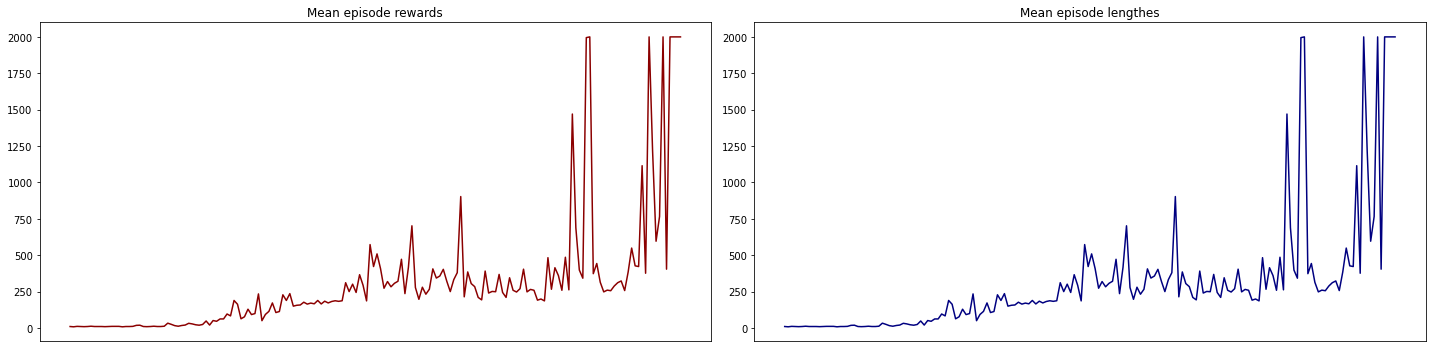

In [31]:
plot_rews_lens(rews=rews, lens=lens, window_n=1)

## Save

In [32]:
# SAVE result
torch.save(model.state_dict(), 'model_weights.pth')